<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/ADMET_MLP_AT_GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [246]:
from os import walk
import os
files = next(walk('/content/drive/MyDrive/ADMET/'), (None, None, []))[2]
for file in files:
    if isinstance(file, str):
        file_type = file.split('.')[-1]
        # print(file_type)
        if file_type == 'bin' or file_type == 'pth':
            os.remove(file)

# Evaluation Functions
#### classification already writen in scripts eval_utils

#### regression: here:

In [ ]:
from scripts.eval_utils import *
from scripts.preprocess_mols import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

device = 'cuda'
import sklearn.metrics as metrics

import numpy as np

def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    print('MAE,      MSE,      RMSE,      R2')
    print("& %5.3f" % (mae), " &%5.3f" % (mse), " &%5.3f" % (rmse),
      " &%5.3f" % (r2))

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

def eval_dict(y_probs:dict, y_label:dict, names:list, IS_R, draw_fig=False):
    if isinstance(IS_R, list): task_list = IS_R
    else: task_list = [IS_R] * len(names)
    for i, (name, IS_R) in enumerate(zip(names, task_list)):
        # IS_R = task_list[i]
        print('*'*15, name, '*'*15)
        # print('Regression task', IS_R)

        probs = y_probs[name]
        label = y_label[name]
        assert len(probs) == len(label)
        if IS_R == False: # classification task
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)

        else: # regression task
            r2, mae, rmse = reg_evaluate(label, probs)
            if draw_fig:
                color = mcp.gen_color_normalized(cmap='viridis',
                                                data_arr=label)
                plt.scatter(label, probs, cmap='viridis', marker='.',
                            s=10, alpha=0.5, edgecolors='none', c=color)
                plt.xlabel(f'True {name}')
                plt.ylabel(f'Predicted {name}')
                plt.title(f'{name} prediction on test set')

                x0, xmax = plt.xlim()
                y0, ymax = plt.ylim()
                data_width = xmax - x0
                data_height = ymax - y0
                # print(x0, xmax, y0, ymax, data_width, data_height)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

                plt.show()
                plt.cla()
                plt.clf()
                plt.close()
        print()


# Models architecture

#### Classifier: MLP

#### AttentiveFP


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, **config):
        super(Classifier, self).__init__()
        dims = [config['in_dim'], config['hid_dims'], config['out_dim']]
        self.dims = dims
        neurons = [config['in_dim'], *config['hid_dims']]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(config['hid_dims'][-1], config['out_dim'])
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        for layer in self.hidden: x = F.relu(layer(x))
        x = self.final(x)
        return self.dropout(x)

    def get_dim(self): return self.dims


In [4]:
import time
import pandas as pd
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset



def get_model_AT_10_17(names, n_layers, graph_feat_size, dropout):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1,
            graph_feat_size=graph_feat_size,
            n_tasks=len(names), dropout=dropout)
    return model

In [5]:

def AttentiveFP(**config):
    return get_model_AT_10_17(config['prop_names'], config['n_layers'],
                                    config['in_dim'], config['dropout'])

# AttentiveFP(**config_AttentiveFP)

GIN

In [7]:

class GIN_MOD(nn.Module):
    """
    Reference: https://github.com/kexinhuang12345/DeepPurpose/blob/master/DeepPurpose/encoders.py#L392
    """
	## adapted from https://github.com/awslabs/dgl-lifesci/blob/2fbf5fd6aca92675b709b6f1c3bc3c6ad5434e96/examples/property_prediction/moleculenet/utils.py#L76
    def __init__(self, **config):
        super(GIN_MOD, self).__init__()
        self.gnn = load_pretrained('gin_supervised_contextpred')
        self.readout = AvgPooling()
        self.transform = nn.Linear(300, config['in_dim'])
        self.dropout = nn.Dropout(config['dropout'])
        self.hidden_dims = config['hid_dims']
        self.out_dim = config['out_dim']
        layer_size = len(self.hidden_dims)
        neurons = [config['in_dim'], *self.hidden_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(self.hidden_dims[-1], self.out_dim)

    def forward(self, bg):
        # bg = bg.to(device)
        node_feats = [
            bg.ndata.pop('atomic_number'),
            bg.ndata.pop('chirality_type')
        ]
        edge_feats = [
            bg.edata.pop('bond_type'),
            bg.edata.pop('bond_direction_type')
        ]

        node_feats = self.gnn(bg, node_feats, edge_feats)
        x = self.readout(bg, node_feats)
        x = self.transform(x)
        for layer in self.hidden: x = F.leaky_relu(layer(x))
        x = self.final(x)
        return self.dropout(x)


# Train eval test functions

In [237]:

def train_epoch_MLP(model, loader, IS_R, names, device, epoch=None,
                    optimizer=None, MASK=-100, scale_dict=None):
    if optimizer==None: # no optimizer, either validation or test
        model.eval()    # model evaluation for either valid or test
        if epoch != None: train_type='Valid' # if epoch is inputted, its valid
        else: train_type = 'Test' # if no epoch information, its test
    else: model.train(); train_type='Train' # if optimizer inputted, its train

    if isinstance(IS_R, list): IS_R_list = IS_R
    else: IS_R_list = [IS_R] * len(names)
    losses = 0
    y_probs = {}
    y_label = {}
    for idx, batch_data in enumerate(loader):
        """
        len(batch_data) could determine which algorithm
        len(batch_data) == 2: MLP, GIN
        len(batch_data) == 4: AttentiveFP
        """
        if len(batch_data) == 2:  # MLP or GIN
            fp, labels = batch_data
            fp, labels = fp.to(device), labels.to(device)
            mask = labels == MASK
            pred = model(fp)
        elif len(batch_data) == 4: # attentiveFP
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            pred = model(bg, n_feats, e_feats)
            mask = masks < 1

        for j, (name, IS_R) in enumerate(zip(names, IS_R_list)):
            loss_func = get_loss_fn(IS_R)
            probs = pred[:, j][~mask[:, j]]
            label = labels[:, j][~mask[:, j]]
            if j == 0: loss = loss_func(probs, label)
            else: loss += loss_func(probs, label)
            if IS_R == False: probs = F.sigmoid(probs)

            if train_type != 'Train': # validation
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if scale_dict != None:
                    min_here = scale_dict[name][0]
                    max_here = scale_dict[name][1]
                    del_here = max_here - min_here
                    label = [l * del_here + min_here for l in label]
                    probs = [p * del_here + min_here for p in probs]

                if idx ==0: y_probs[name], y_label[name] = probs, label
                else:
                    y_probs[name] += probs
                    y_label[name] += label

        losses += loss.item()
        if optimizer != None: optimizer.zero_grad(); loss.backward(); optimizer.step()

    total_loss = losses / len(loader.dataset)
    if epoch != None: # train or valid
        print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    else: # test
        print(f'[{train_type}] Loss: {total_loss:.3f}')
        eval_dict(y_probs, y_label, names, IS_R_list, draw_fig=True)

    if train_type == 'train': return total_loss
    else: return total_loss, y_probs, y_label


# dataset and dataloader functions

In [101]:
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys
import torch.nn.functional as F

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

import torch
def process(data):

    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

MASK = -100

class nn_dataset(Dataset):
    def __init__(self, df, prop_names, mask=MASK):
        super(nn_dataset, self).__init__()
        df = process(df)
        df = df.fillna(mask)
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        if isinstance(prop_names, str): prop_names = [prop_names]
        self.props = self.df[prop_names]

    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

    def __len__(self): return self.len

    def get_df(self): return self.df

AttentiveFP

In [10]:

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks

def get_AttentiveFP_dataset(df, name):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", time.localtime())

    params = {'smiles_to_graph': smiles_to_bigraph,
            'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            'cache_file_path': time_string+'.bin',
            'task_names': name, 'load': True, 'n_jobs': len(name)*2}
    graph_dataset = MoleculeCSVDataset(df, **params)
    return graph_dataset

def get_AttentiveFP_loader(df, name, **loader_params):
    dataset = get_AttentiveFP_dataset(df, name)
    loader_params['collate_fn'] = collate_molgraphs
    loader = DataLoader(dataset, **loader_params)
    return loader

GIN data set and data loader

In [102]:
from dgllife.model import load_pretrained
from dgl.nn.pytorch.glob import AvgPooling
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch
from dgllife.utils import smiles_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer

MASK = -100

class GIN_dataset(Dataset):
    def __init__(self, df, names, mask=MASK):
        df = df.fillna(mask)
        self.names = names
        self.df = df
        self.len = len(df)
        self.props = self.df[names]
        self.node_featurizer = PretrainAtomFeaturizer()
        self.edge_featurizer = PretrainBondFeaturizer()
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)
    def __len__(self): return self.len
    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['Drug']
        v_d = self.fc(smiles=v_d, node_featurizer = self.node_featurizer,
                      edge_featurizer = self.edge_featurizer)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return v_d, label

import dgl
def get_GIN_dataloader(datasets, **loader_params):
    def dgl_collate_func(data):
        x, labels = map(list, zip(*data))
        bg = dgl.batch(x)
        labels = torch.stack(labels, dim=0)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)
        return bg, labels
    loader_params['collate_fn'] = dgl_collate_func
    return DataLoader(datasets, **loader_params)

In [238]:
def init_model(**config):
    """need incorporate all models here! """
    if config['model_type'] == 'MLP':
        model = Classifier(**config)
    elif config['model_type'] == 'GIN':
        model = GIN_MOD(**config) # need work config GIN out_dim
    elif config['model_type'] == 'AttentiveFP':
        model = AttentiveFP(**config)
    elif config['model_type'] == 'RNN': pass
    return model

def get_loss_fn(IS_R):
    if IS_R: return nn.MSELoss(reduction='sum')
    else: return nn.BCEWithLogitsLoss(reduction='sum')

def get_train_fn(model_type):
    if model_type == 'MLP': return train_epoch_MLP

    elif model_type == 'GIN': return train_epoch_MLP
    elif model_type == 'AttentiveFP': return train_epoch_MLP
    elif model_type == 'RNN': pass

def get_eval_fn(model_type):
    if model_type == 'MLP': return train_epoch_MLP

    elif model_type == 'GIN': return train_epoch_MLP
    elif model_type == 'AttentiveFP': return train_epoch_MLP
    elif model_type == 'RNN': pass


def get_loader(df, names, params, model_type):
    print('--> preparing data loader for model type ', model_type)
    if model_type == 'MLP': return DataLoader(nn_dataset(df, names), **params)

    elif model_type == 'GIN':
        return get_GIN_dataloader(GIN_dataset(df, names), **params)

    elif model_type == 'AttentiveFP':
        return get_AttentiveFP_loader(df, names, **params)

    elif model_type == 'RNN': pass


In [239]:
from scripts.preprocess_mols import preprocess, rename_cols, clean_mol, scal
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')

def collect_data_10_17(names:list, clean_mol_=False):
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        if name in label_list:
            data = Tox(name='herg_central', label_name=name)
        else:
            try: data = ADME(name=name)
            except:
                try: data = Tox(name=name)
                except: print('cannot read data!'); break
            # data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0: trains, valids, tests = train, valid, test
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests


In [240]:
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm

class PRED:
    def __init__(self, **config):
        cuda = torch.cuda.is_available()
        if cuda: self.device = 'cuda'
        else:    self.device = 'cpu'
        self.prop_names = config['prop_names']
        self.config = config
        if 'scale_dict' in config:
            self.scale_dict = config['scale_dict']
        else: self.scale_dict = None
        self.model_type = config['model_type']
        print('model type: ', self.model_type)
        self.model_path = config['model_path']

        self.eval_fn = get_eval_fn(self.model_type)
        self.train_fn = get_train_fn(self.model_type)

        self.model = init_model(**config).to(self.device)

        self.IS_R = config['IS_R'] # could be list, could be true/false
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                        lr=config['lr'], weight_decay=config['wd'])
        self.stopper = EarlyStopping(mode='lower', patience=config['patience'])

        self.min_loss = np.inf
        self.best_epoch = 0

    def load_model(self, path):
        con = self.config.copy()
        con['dropout'] = 0
        self.model = init_model(**con).to(self.device)
        print('load pretrained model from ', path)
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def eval(self, loader, path=None):
        if path != None: self.load_model(path)
        self.eval_fn(self.model, loader, self.IS_R, self.prop_names, self.device,
               epoch=None, optimizer=None, MASK=-100, scale_dict=self.scale_dict)

    def train(self, data_loader, val_loader, test_loader=None):
        if self.best_epoch != 0: self.load_model(self.model_path)

        for epoch in range(500):
            score = self.train_fn(self.model, data_loader, self.IS_R,
                                  self.prop_names, self.device, epoch,
                                  self.optimizer, scale_dict=self.scale_dict)
            val_score, probs, labels = self.train_fn(self.model, val_loader,
                                       self.IS_R, self.prop_names, self.device,
                                       epoch, scale_dict=self.scale_dict)

            early_stop = self.stopper.step(val_score, self.model)
            if val_score < self.min_loss:
                print(f'prev min loss {self.min_loss:.3f}, '
                      f'now loss {val_score:.3f} |',
                      f'save model at epoch: {epoch}')
                self.min_loss = val_score
                torch.save(self.model.state_dict(), self.model_path)
                self.best_epoch = epoch
                eval_dict(probs, labels, self.prop_names, IS_R=self.IS_R)

            if early_stop: print('early stop'); break

        print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
        print()
        if test_loader != None: self.eval(test_loader, self.model_path)



# TEST MLP MO

In [ ]:
names = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
         'CYP1A2_Veith', 'CYP2C9_Veith']

IS_R = [False] * len(names)

trains, valids, tests = collect_data_10_17(names)

In [154]:
import pandas as pd
def count_(df:pd.DataFrame):
    for col in df.columns:
        if col != 'Drug':
            try:
                ones = df[col].value_counts()[1]
                zero = df[col].value_counts()[0]
            except: ones = 'Nan'; zero = 'Nan'
            print(col, f'\t 0: {zero} | 1: {ones}')
    print()

count_(trains), count_(valids), count_(tests)

CYP2C19_Veith 	 0: 4803 | 1: 4063
CYP2D6_Veith 	 0: 7425 | 1: 1766
CYP3A4_Veith 	 0: 5052 | 1: 3577
CYP1A2_Veith 	 0: 4745 | 1: 4060
CYP2C9_Veith 	 0: 5652 | 1: 2813

CYP2C19_Veith 	 0: 673 | 1: 593
CYP2D6_Veith 	 0: 1053 | 1: 260
CYP3A4_Veith 	 0: 717 | 1: 516
CYP1A2_Veith 	 0: 677 | 1: 581
CYP2C9_Veith 	 0: 796 | 1: 413

CYP2C19_Veith 	 0: 1370 | 1: 1163
CYP2D6_Veith 	 0: 2138 | 1: 488
CYP3A4_Veith 	 0: 1449 | 1: 1017
CYP1A2_Veith 	 0: 1328 | 1: 1188
CYP2C9_Veith 	 0: 1599 | 1: 819



(None, None, None)

In [ ]:
batch_size = 64
loader_params = {'batch_size': batch_size, 'shuffle': True}
train_loader = get_loader(trains, names, loader_params, 'MLP')
valid_loader = get_loader(valids, names, loader_params, 'MLP')

test_params = {'batch_size': batch_size, 'shuffle': False}
test_loader  = get_loader(tests,  names,  test_params,  'MLP')

In [ ]:
in_dim = 167
hid_dims = [256]
dropout = 0.1
lr = 3e-4
wd = 1e-5
patience = 10

config = {'model_type': 'MLP',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt.pt'}
print(config)
models = PRED(**config)
models.train(train_loader, valid_loader)

In [85]:
models.eval(test_loader, config['model_path'])

load pretrained model from  ckpt.pt
[Test] Loss: 0.550
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.803  &  0.802  &          0.782  &     0.791  &0.812  &0.786 &0.879 &   0.603 &   0.850

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.869  &  0.722  &          0.715  &     0.488  &0.956  &0.580 &0.852 &   0.518 &   0.659

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.777  &  0.761  &          0.764  &     0.667  &0.855  &0.712 &0.860 &   0.535 &   0.806

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.836  &  0.837  &          0.812  &     0.848  &0.825  &0.830 &0.914 &   0.672 &   0.903

*************** CYP2C9_Veith ***********

# TEST ATTENTIVEFP MO

In [ ]:
loader_params = {'batch_size': batch_size, 'shuffle': True}
train_loader = get_loader(trains, names, loader_params, 'AttentiveFP')
valid_loader = get_loader(valids, names, loader_params, 'AttentiveFP')

test_params = {'batch_size': batch_size, 'shuffle': False}
test_loader  = get_loader(tests,  names,  test_params,  'AttentiveFP')

In [ ]:
n_layers = 5
graph_feat_size = 300
config_AT = {'model_type': 'AttentiveFP',
          'in_dim': graph_feat_size,
          'n_layers': n_layers,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_AT.pt'}

print(config_AT)
models = PRED(**config_AT)
models.train(train_loader, valid_loader)

In [89]:
models.eval(test_loader, config_AT['model_path'])

load pretrained model from  ckpt_AT.pt
[Test] Loss: 0.480
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.835  &  0.837  &          0.801  &     0.853  &0.820  &0.826 &0.909 &   0.671 &   0.889

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.887  &  0.771  &          0.753  &     0.586  &0.956  &0.659 &0.887 &   0.599 &   0.726

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.822  &  0.814  &          0.794  &     0.767  &0.861  &0.780 &0.909 &   0.631 &   0.867

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.878  &  0.876  &          0.895  &     0.840  &0.912  &0.867 &0.944 &   0.756 &   0.941

*************** CYP2C9_Veith ********

# Train GIN

In [93]:
loader_params = {'batch_size': batch_size, 'shuffle': True}
train_loader = get_loader(trains, names, loader_params, 'GIN')
valid_loader = get_loader(valids, names, loader_params, 'GIN')

test_params = {'batch_size': batch_size, 'shuffle': False}
test_loader  = get_loader(tests,  names,  test_params,  'GIN')

--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN


In [110]:
config_GIN = {'model_type': 'GIN',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_GIN.pt'}

print(config_GIN)
models = PRED(**config_GIN)
models.train(train_loader, valid_loader)

Epoch:27, [Train] Loss: 1.079
Epoch:27, [Valid] Loss: 0.363
EarlyStopping counter: 8 out of 10
Epoch:28, [Train] Loss: 1.083
Epoch:28, [Valid] Loss: 0.366
EarlyStopping counter: 9 out of 10
Epoch:29, [Train] Loss: 1.075
Epoch:29, [Valid] Loss: 0.364
EarlyStopping counter: 10 out of 10
early stop
best epoch: 19, min loss: 0.3622



In [115]:
models.eval(test_loader, config_GIN['model_path'])

Pretrained model loaded
load pretrained model from  ckpt_GIN.pt
[Test] Loss: 0.427
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.856  &  0.856  &          0.836  &     0.854  &0.858  &0.845 &0.929 &   0.710 &   0.915

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.888  &  0.783  &          0.741  &     0.615  &0.951  &0.672 &0.904 &   0.609 &   0.760

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.837  &  0.833  &          0.801  &     0.806  &0.859  &0.804 &0.920 &   0.665 &   0.886

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.885  &  0.885  &          0.866  &     0.894  &0.877  &0.880 &0.950 &   0.770 &   0.945

************

# Regression task test

In [ ]:
names = ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']
# 'Caco2_Wang',  always R2 <0 do not know why 'HydrationFreeEnergy_FreeSolv'
# names = ['Caco2_Wang', 'Lipophilicity_AstraZeneca'] + names # ,'Lipophilicity_AstraZeneca'
IS_R = [True] * len(names)
trains, valids, tests = collect_data_10_17(names)

len(trains), len(valids), len(tests), trains

In [159]:
def scale(trains, valids, tests):
    print('scaling train valid test data set for regression task ')
    dict_scale = {}
    for col in trains.columns:
        if col == 'Drug': pass
        else:
            # print(col)
            min_here = min(trains[col].min(), valids[col].min(), tests[col].min())
            max_here = max(trains[col].max(), valids[col].max(), tests[col].max())
            dict_scale[col] = [min_here, max_here]
            delta_here = max_here - min_here
            trains[col] = (trains[col] - min_here) / delta_here
            valids[col] = (valids[col] - min_here) / delta_here
            tests[col]  = (tests[col]  - min_here) / delta_here

    return trains, valids, tests, dict_scale


# t, v, te = collect_data_10_17(names)
trains, valids, tests, dict_scale = scale(trains, valids, tests)

trains

scaling train valid test data set for regression task 


,Drug,Lipophilicity_AstraZeneca,Solubility_AqSolDB
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,0.840000,NaN
1,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,0.053333,NaN
2,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,0.865000,NaN
3,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,0.773333,NaN
4,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,0.501667,NaN
...,...,...,...
9816,CC(C)NCC(O)COc1cccc2[nH]ccc12,NaN,0.612812
9817,O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,NaN,0.655923
9818,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...,NaN,0.640246
9819,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc(S(C)=O)cc1,NaN,0.566436


In [160]:
dict_scale

{'Lipophilicity_AstraZeneca': [-1.5, 4.5],
 'Solubility_AqSolDB': [-13.1719, 2.1376816201]}

### MLP

In [161]:
batch_size = 64
loader_params = {'batch_size': batch_size, 'shuffle': True}
train_loader = get_loader(trains, names, loader_params, 'MLP')
valid_loader = get_loader(valids, names, loader_params, 'MLP')

test_params = {'batch_size': batch_size, 'shuffle': False}
test_loader  = get_loader(tests,  names,  test_params,  'MLP')

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


In [ ]:
in_dim = 167
hid_dims = [256, 32]
dropout = 0
lr = 3e-4
wd = 1e-5
patience = 10

config = {'model_type': 'MLP',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt.pt',
          'scale_dict': dict_scale}
print(config)
models = PRED(**config)
models.train(train_loader, valid_loader)

load pretrained model from  ckpt.pt
[Test] Loss: 0.011
*************** Lipophilicity_AstraZeneca ***************
MAE,      MSE,      RMSE,      R2
& 0.662  &0.737  &0.858  &0.501


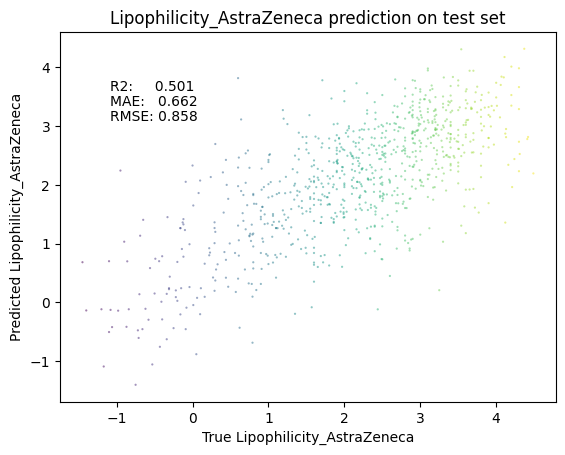


*************** Solubility_AqSolDB ***************
MAE,      MSE,      RMSE,      R2
& 0.949  &1.639  &1.280  &0.698


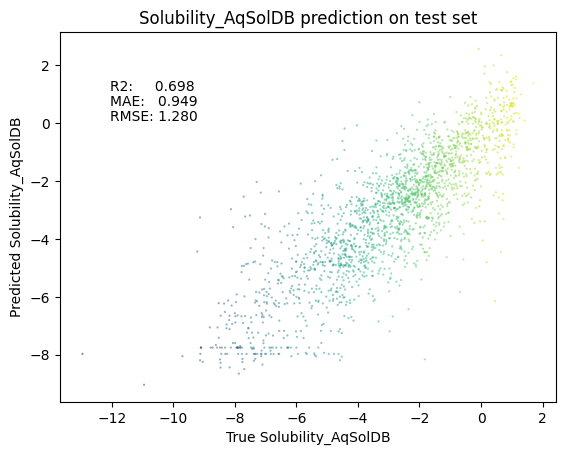

In [163]:
models.eval(test_loader, config['model_path'])

AttentiveFP MO regression task

In [ ]:
batch_size = 128
loader_params = {'batch_size': batch_size, 'shuffle': True,
                 'drop_last': False, 'num_workers':0}
train_loader = get_loader(trains, names, loader_params, 'AttentiveFP')
valid_loader = get_loader(valids, names, loader_params, 'AttentiveFP')

test_params = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers':0}
test_loader  = get_loader(tests,  names,  test_params,  'AttentiveFP')

In [ ]:
n_layers = 5
graph_feat_size = 300
dropout = 0.1
config_AT = {'model_type': 'AttentiveFP',
          'in_dim': graph_feat_size,
          'n_layers': n_layers,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_AT.pt',
          'scale_dict': dict_scale}

print(config_AT)
models = PRED(**config_AT)
models.train(train_loader, valid_loader)

load pretrained model from  ckpt_AT.pt
[Test] Loss: 0.006
*************** Lipophilicity_AstraZeneca ***************
MAE,      MSE,      RMSE,      R2
& 0.453  &0.379  &0.615  &0.744


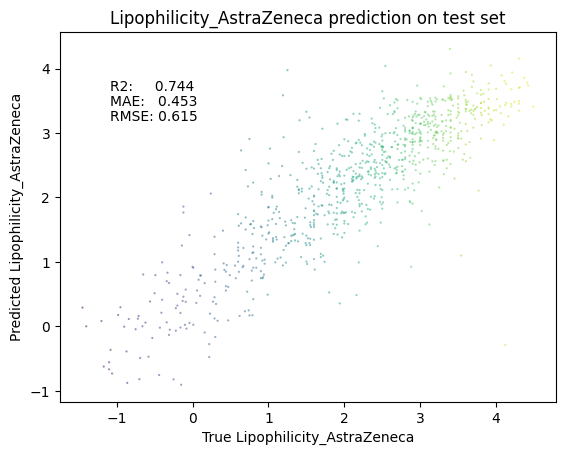


*************** Solubility_AqSolDB ***************
MAE,      MSE,      RMSE,      R2
& 0.692  &1.012  &1.006  &0.813


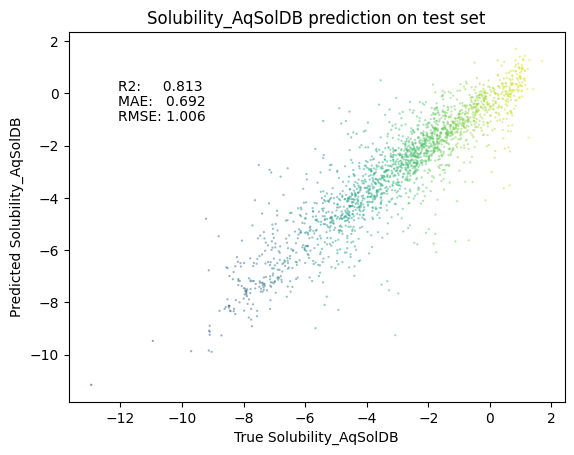

In [169]:
models.eval(test_loader, config_AT['model_path'])

# GIN regression task

In [171]:
loader_params = {'batch_size': batch_size, 'shuffle': True,
                 'drop_last': False, 'num_workers':0}
train_loader = get_loader(trains, names, loader_params, 'GIN')
valid_loader = get_loader(valids, names, loader_params, 'GIN')

test_params = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers':0}
test_loader  = get_loader(tests,  names,  test_params,  'GIN')

config_GIN = {'model_type': 'GIN',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_GIN.pt',
          'scale_dict': dict_scale}

print(config_GIN)
models = PRED(**config_GIN)
models.train(train_loader, valid_loader)

Epoch:49, [Train] Loss: 0.057
Epoch:49, [Valid] Loss: 0.013
EarlyStopping counter: 10 out of 10
early stop
best epoch: 39, min loss: 0.0109



Pretrained model loaded
load pretrained model from  ckpt_GIN.pt
[Test] Loss: 0.011
*************** Lipophilicity_AstraZeneca ***************
MAE,      MSE,      RMSE,      R2
& 0.630  &0.626  &0.791  &0.576


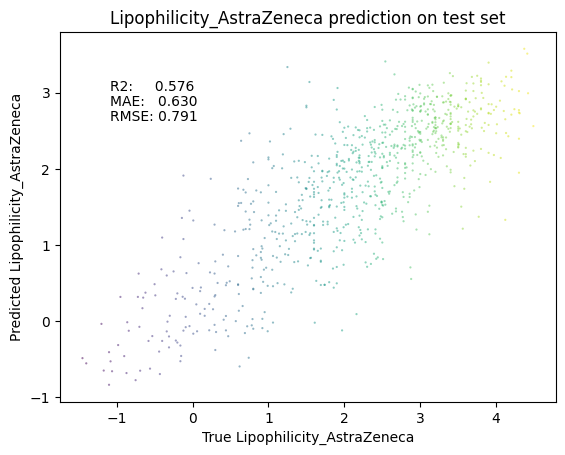


*************** Solubility_AqSolDB ***************
MAE,      MSE,      RMSE,      R2
& 1.069  &1.857  &1.363  &0.658


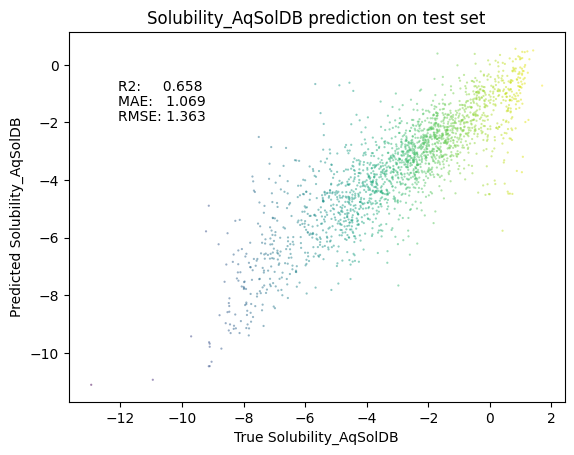

In [172]:
models.eval(test_loader, config_GIN['model_path'])

BBB F, Pgp HIA PAMPA

In [ ]:
names = ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS']

names = ['BBB_Martins', 'Pgp_Broccatelli', 'HIA_Hou']
IS_R = [False] * len(names)
trains, valids, tests = collect_data_10_17(names)

In [191]:
import pandas as pd
def count_(df:pd.DataFrame):
    for col in df.columns:
        if col != 'Drug':
            try:
                ones = df[col].value_counts()[1]
                zero = df[col].value_counts()[0]
            except: ones = 'Nan'; zero = 'Nan'
            print(col, f'\t 0: {zero} | 1: {ones}')
    print()

count_(trains), count_(valids), count_(tests)

BBB_Martins 	 0: 325 | 1: 1096
Pgp_Broccatelli 	 0: 392 | 1: 461
HIA_Hou 	 0: 53 | 1: 353

BBB_Martins 	 0: 51 | 1: 152
Pgp_Broccatelli 	 0: 56 | 1: 66
HIA_Hou 	 0: 6 | 1: 52

BBB_Martins 	 0: 103 | 1: 303
Pgp_Broccatelli 	 0: 121 | 1: 123
HIA_Hou 	 0: 19 | 1: 97



(None, None, None)

In [ ]:
batch_size = 64
loader_params = {'batch_size': batch_size, 'shuffle': True,
                 'drop_last':False, 'num_workers': 0}
train_loader = get_loader(trains, names, loader_params, 'MLP')
valid_loader = get_loader(valids, names, loader_params, 'MLP')

test_params = {'batch_size': batch_size, 'shuffle': False,
               'drop_last':False, 'num_workers': 0}
test_loader  = get_loader(tests,  names,  test_params,  'MLP')

In [ ]:
in_dim = 167
hid_dims = [256, 64]
dropout = 0.
lr = 5e-4
wd = 1e-5
patience = 10

config = {'model_type': 'MLP',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt.pt'}
print(config)
models = PRED(**config)
models.train(train_loader, valid_loader)

In [195]:
models.eval(test_loader, config['model_path'])

load pretrained model from  ckpt.pt
[Test] Loss: 0.393
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.855  &  0.755  &          0.863  &     0.957  &0.553  &0.908 &0.881 &   0.588 &   0.945

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.783  &  0.783  &          0.769  &     0.813  &0.752  &0.791 &0.852 &   0.566 &   0.876

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.931  &  0.811  &          0.932  &     0.990  &0.632  &0.960 &0.965 &   0.729 &   0.993



AttentiveFP

In [ ]:
train_loader = get_loader(trains, names, loader_params, 'AttentiveFP')
valid_loader = get_loader(valids, names, loader_params, 'AttentiveFP')
test_loader  = get_loader(tests,  names,  test_params,  'AttentiveFP')

In [ ]:
n_layers = 5
graph_feat_size = 300
lr = 5e-4
wd = 1e-5
config_AT = {'model_type': 'AttentiveFP',
          'in_dim': graph_feat_size,
          'n_layers': n_layers,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_AT.pt'}

print(config_AT)
models = PRED(**config_AT)
models.train(train_loader, valid_loader)

In [198]:
models.eval(test_loader, config_AT['model_path'])

load pretrained model from  ckpt_AT.pt
[Test] Loss: 0.295
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.892  &  0.849  &          0.922  &     0.934  &0.765  &0.928 &0.905 &   0.708 &   0.956

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.869  &  0.868  &          0.879  &     0.879  &0.857  &0.879 &0.929 &   0.736 &   0.912

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.948  &  0.824  &          0.962  &     0.981  &0.667  &0.971 &0.994 &   0.703 &   0.999



# GIN

In [ ]:
train_loader = get_loader(trains, names, loader_params, 'GIN')
valid_loader = get_loader(valids, names, loader_params, 'GIN')
test_loader  = get_loader(tests,  names,  test_params,  'GIN')

dropout = 0.3

config_GIN = {'model_type': 'GIN',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_GIN.pt'}

print(config_GIN)
models = PRED(**config_GIN)
models.train(train_loader, valid_loader)

In [202]:
models.eval(test_loader, config_GIN['model_path'])

Pretrained model loaded
load pretrained model from  ckpt_GIN.pt
[Test] Loss: 0.358
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.867  &  0.786  &          0.881  &     0.950  &0.621  &0.914 &0.919 &   0.629 &   0.969

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.795  &  0.795  &          0.807  &     0.780  &0.810  &0.793 &0.889 &   0.591 &   0.910

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.948  &  0.863  &          0.950  &     0.990  &0.737  &0.970 &0.967 &   0.801 &   0.993



In [200]:
models.eval(test_loader, config_GIN['model_path'])

Pretrained model loaded
load pretrained model from  ckpt_GIN.pt
[Test] Loss: 0.380
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.867  &  0.789  &          0.883  &     0.947  &0.631  &0.914 &0.910 &   0.630 &   0.963

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.820  &  0.820  &          0.826  &     0.813  &0.826  &0.820 &0.892 &   0.639 &   0.911

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.948  &  0.884  &          0.960  &     0.979  &0.789  &0.969 &0.984 &   0.805 &   0.997



# MIX regression and classification

In [ ]:
names = ['LD50_Zhu', 'hERG_Karim', 'AMES']
IS_R = [True, False, False]
trains, valids, tests = collect_data_10_17(names)
trains, valids, tests, dict_scale = scale(trains, valids, tests)

trains

In [231]:
for i, j in zip(names, IS_R):
    print(i, j)

LD50_Zhu True
hERG_Karim False
AMES False


In [ ]:
batch_size = 64
loader_params = {'batch_size': batch_size, 'shuffle': True,
                 'drop_last': False, 'num_workers': 0}
train_loader = get_loader(trains, names, loader_params, 'MLP')
valid_loader = get_loader(valids, names, loader_params, 'MLP')

test_params = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers': 0}
test_loader  = get_loader(tests,  names,  test_params,  'MLP')

In [ ]:
in_dim = 167
hid_dims = [256]
dropout = 0.1
lr = 3e-4
wd = 1e-5
patience = 10

config = {'model_type': 'MLP',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt.pt',
          'scale_dict': dict_scale}
print(config)
models = PRED(**config)
models.train(train_loader, valid_loader)

load pretrained model from  ckpt.pt
[Test] Loss: 0.327
*************** LD50_Zhu ***************
Regression task True
MAE,      MSE,      RMSE,      R2
& 0.528  &0.500  &0.707  &0.441


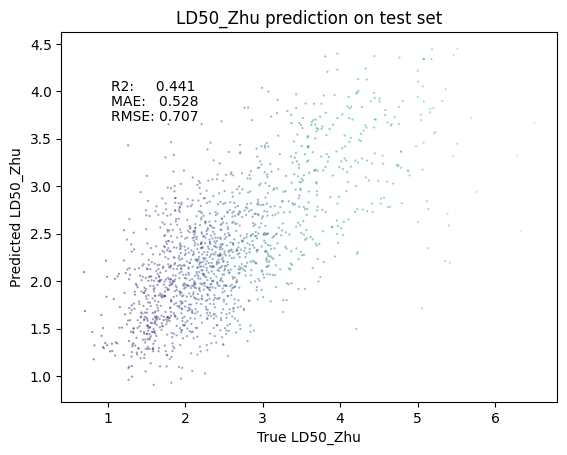


*************** hERG_Karim ***************
Regression task False
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.799  &  0.799  &          0.785  &     0.824  &0.775  &0.804 &0.878 &   0.599 &   0.886

*************** AMES ***************
Regression task False
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.816  &  0.812  &          0.819  &     0.852  &0.772  &0.835 &0.887 &   0.627 &   0.895



In [242]:
models.eval(test_loader, config['model_path'])

# MIX TASK AttentiveFP

In [249]:
train_loader = get_loader(trains, names, loader_params, 'AttentiveFP')
valid_loader = get_loader(valids, names, loader_params, 'AttentiveFP')
test_loader  = get_loader(tests,  names,  test_params,  'AttentiveFP')

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 4468 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done 12468 tasks      | elapsed:   12.1s
[Parallel(n_jobs=6)]: Done 18928 out of 18928 | elapsed:   18.6s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 2732 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done 2791 out of 2791 | elapsed:    3.3s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 4468 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 5551 out of 5551 | elapsed:    5.9s finished


In [ ]:
n_layers = 5
graph_feat_size = 300
dropout = 0.3
config_AT = {'model_type': 'AttentiveFP',
          'in_dim': graph_feat_size,
          'n_layers': n_layers,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt_AT.pt',
          'scale_dict': dict_scale}

print(config_AT)
models = PRED(**config_AT)
models.train(train_loader, valid_loader)


Epoch:19, [Train] Loss: 0.326
Epoch:19, [Valid] Loss: 0.341
prev min loss 0.342, now loss 0.341 | save model at epoch: 19
*************** LD50_Zhu ***************
Regression task True
MAE,      MSE,      RMSE,      R2
& 0.574  &0.600  &0.774  &0.373

*************** hERG_Karim ***************
Regression task False
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.769  &  0.769  &          0.771  &     0.755  &0.783  &0.763 &0.860 &   0.539 &   0.865

*************** AMES ***************
Regression task False
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.819  &  0.815  &          0.843  &     0.839  &0.791  &0.841 &0.879 &   0.630 &   0.888

Epoch:20, [Train] Loss: 0.318
Epoch:20, [Valid] Loss: 0.328
prev min loss 0.341, now loss 0.328 | save model at epoch: 20
*************** LD50_Zhu ***************
Regression task True
MAE,      MSE,      RMSE,      R2
& 0.584  &0.605  &0.778  &0.367

************

In [ ]:
# test_loader  = get_loader(tests,  names,  test_params,  'AttentiveFP')
models.eval(test_loader, config['model_path'])

In [21]:
# names = ['k', 'b', 'd', 'f', 'a']
# IS_R = True
patience = 30
dropout = 0.1
in_dim = 167 # len of fingerprint
out_dim = len(names)
hid_dims = [128, 64, 32, 16] # hidden dims changeable
lr = 3e-4
wd = 1e-5

dims = [in_dim, hid_dims, out_dim]
print(dims)

config = {'model_type': 'MLP',
          'in_dim': in_dim,
          'hid_dims': hid_dims,
          'out_dim': len(names),
          'prop_names': names,
          'dropout': dropout,
          'IS_R': IS_R,
          'lr': lr,
          'wd': wd,
          'patience': patience,
          'model_path': 'ckpt.pt'}

[167, [128, 64, 32, 16], 5]


In [22]:
model = Classifier(**config)
cuda = torch.cuda.is_available()

if cuda: model = model.cuda(); device = 'cuda'
else: device = 'cpu'
from torchsummary import summary
batch_size = 128
summary(model, (batch_size, config['in_dim']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 128]          21,504
            Linear-2              [-1, 128, 64]           8,256
            Linear-3              [-1, 128, 32]           2,080
            Linear-4              [-1, 128, 16]             528
            Linear-5               [-1, 128, 5]              85
           Dropout-6               [-1, 128, 5]               0
Total params: 32,453
Trainable params: 32,453
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [18]:
model = Classifier(**config)
cuda = torch.cuda.is_available()

if cuda: model = model.cuda(); device = 'cuda'
else: device = 'cpu'
from torchsummary import summary
batch_size = 128
summary(model, (batch_size, config['in_dim']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 128]          21,504
            Linear-2              [-1, 128, 64]           8,256
            Linear-3              [-1, 128, 32]           2,080
            Linear-4              [-1, 128, 16]             528
            Linear-5               [-1, 128, 1]              17
           Dropout-6               [-1, 128, 1]               0
Total params: 32,385
Trainable params: 32,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


In [16]:


train_loss_dict = {}
valid_loss_dict = {}

epochs = 1000
best_epoch = 0

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)


from torchsummary import summary
summary(model, (batch_size, config['in_dim']))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 128]          21,504
            Linear-2              [-1, 128, 64]           8,256
            Linear-3              [-1, 128, 32]           2,080
            Linear-4              [-1, 128, 16]             528
            Linear-5               [-1, 128, 1]              17
           Dropout-6               [-1, 128, 1]               0
Total params: 32,385
Trainable params: 32,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.44
----------------------------------------------------------------
